In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

In [0]:
ROOT_DIR1 = '/content/drive/My Drive/Mask_RCNN-master/log1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Mask_RCNN-master'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Mask_RCNN-master


In [7]:
# Import Mask RCNN
sys.path.append('ROOT_DIR')  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.food_dataset import FoodChallengeDataset
from mrcnn.food_config import Config


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR1, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [8]:
class FoodConfig(Config):
    NAME = "food1"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    NUM_CLASSES =  41  # 1 background + 40 class
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    STEPS_PER_EPOCH = 100 # default
    VALIDATION_STEPS = 5
    
config = FoodConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                53
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [10]:
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(dataset_dir="/content/drive/My Drive/Mask_RCNN-master/train", load_small=False)
dataset_train.prepare()
dataset = dataset_train

dataset_val = FoodChallengeDataset()
dataset_val.load_dataset(dataset_dir="/content/drive/My Drive/Mask_RCNN-master/val", load_small=False)
dataset_val.prepare()

Annotation Path  /content/drive/My Drive/Mask_RCNN-master/train/annotation.json
Image Dir  /content/drive/My Drive/Mask_RCNN-master/train/images
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
Annotation Path  /content/drive/My Drive/Mask_RCNN-master/val/annotation.json
Image Dir  /content/drive/My Drive/Mask_RCNN-master/val/images
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


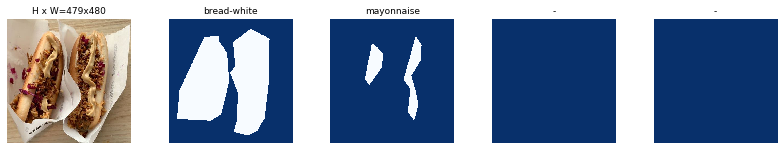

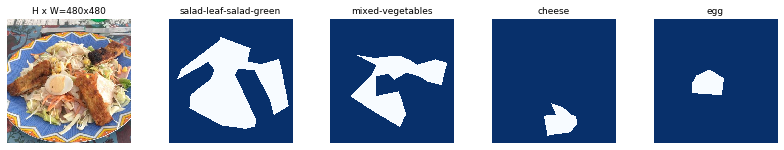

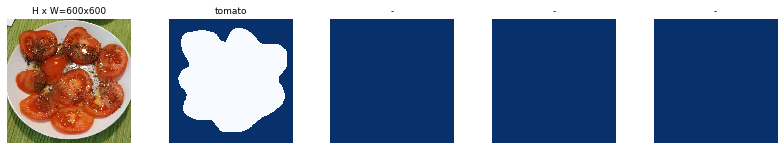

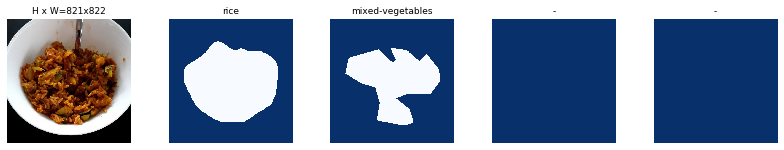

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
# generate new class for Model.
class FoodConfig(Config):
    NAME = "food"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 40
    GPU_COUNT = 1
    DETECTION_MIN_CONFIDENCE = 0
    STEPS_PER_EPOCH = 600

In [0]:
config = FoodConfig()

In [14]:
# created model
model = modellib.MaskRCNN(mode='training',
                          config=config,
                         model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead



In [15]:
# load weight pre-trained cho mode (coco pre-trained weight)
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=['mrcnn_bbox_fc', 'mrcnn_class_logits', 'mrcnn_mask', 'mrcnn_bbox'])

In [0]:
import imgaug.augmenters as augter

augmentation = augter.Sequential([
            augter.Fliplr(0.5), 
            augter.Crop(percent=(0, 0.1)), 
            augter.Sometimes(0.5,
                augter.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            augter.ContrastNormalization((0.75, 1.5)),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            augter.Multiply((0.8, 1.2), per_channel=0),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            augter.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-10, 10),
                shear=(-2, 2))
            ], random_order=True) # apply augmenters in random order

In [18]:
print("Training network heads")

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=12,
            layers='heads',
            augmentation=augmentation)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=36,
            layers='4+',
            augmentation=augmentation)

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=48,
            layers='all',
            augmentation=augmentation)

# Save weights 
# Save log each 5 epochs

model_path = os.path.join(MODEL_DIR, "mask_rcnn_food.h5")
model.keras_model.save_weights(model_path)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Mask_RCNN-master/log1/logs/food20200205T0253/mask_rcnn_food_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/12
600/600 [==============================] - 329s 549ms/step - loss: 1.6163 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.3216 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.3840 - val_loss: 1.5962 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.3466 - val_mrcnn_class_loss: 0.4545 - val_mrcnn_bbox_loss: 0.4075 - val_mrcnn_mask_loss: 0.3821
Epoch 2/12
600/600 [==============================] - 302s 503ms/step - loss: 1.5350 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4887 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.3878 - val_loss: 2.5298 - val_rpn_class_loss: 0.0446 - val_rpn_bbox_loss: 1.4006 - val_mrcnn_class_loss: 0.3201 - val_mrcnn_bbox_loss: 0.4039 - val_mrcnn_mask_loss: 0.3606
Epoch 3/12
600/600 [==============================] - 303s 504ms/step - loss: 1.6927 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5994 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.3701 - val_loss: 1.3835 - val_rp

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 13/36
600/600 [==============================] - 497s 828ms/step - loss: 1.3788 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.3338 - val_loss: 1.2903 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.2747 - val_mrcnn_class_loss: 0.4170 - val_mrcnn_bbox_loss: 0.2825 - val_mrcnn_mask_loss: 0.3106
Epoch 14/36
600/600 [==============================] - 437s 728ms/step - loss: 1.3390 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.2823 - mrcnn_mask_loss: 0.3345 - val_loss: 1.9380 - val_rpn_class_loss: 0.0483 - val_rpn_bbox_loss: 1.0451 - val_mrcnn_class_loss: 0.2785 - val_mrcnn_bbox_loss: 0.2412 - val_mrcnn_mask_loss: 0.3249
Epoch 15/36
600/600 [==============================] - 437s 728ms/step - loss: 1.1955 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.3055 - val_loss: 1.1034 - val

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 37/48
600/600 [==============================] - 564s 940ms/step - loss: 0.9959 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2897 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2850 - val_loss: 1.0105 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.2269 - val_mrcnn_class_loss: 0.2954 - val_mrcnn_bbox_loss: 0.2086 - val_mrcnn_mask_loss: 0.2756
Epoch 38/48
600/600 [==============================] - 501s 835ms/step - loss: 1.0160 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.2839 - val_loss: 1.6124 - val_rpn_class_loss: 0.0646 - val_rpn_bbox_loss: 0.8144 - val_mrcnn_class_loss: 0.2058 - val_mrcnn_bbox_loss: 0.2048 - val_mrcnn_mask_loss: 0.3229
Epoch 39/48
600/600 [==============================] - 502s 836ms/step - loss: 0.9846 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.2645 - val_loss: 0.9526 - val

In [20]:
class InferenceConfig(FoodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/Mask_RCNN-master/log1/logs/food20200205T0253/mask_rcnn_food_0046.h5
Re-starting from epoch 46


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (53,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:   23.00000  max:   23.00000  int32
gt_bbox                  shape: (1, 4)                min:  160.00000  max:  804.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


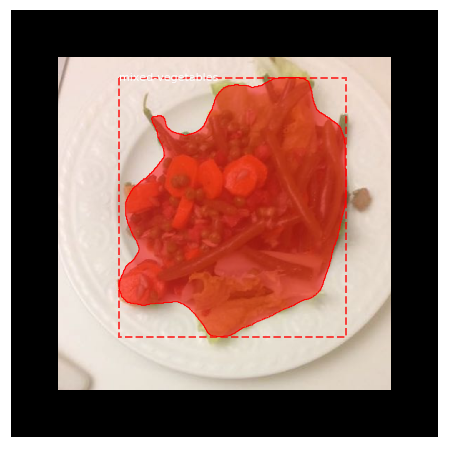

In [21]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 53)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


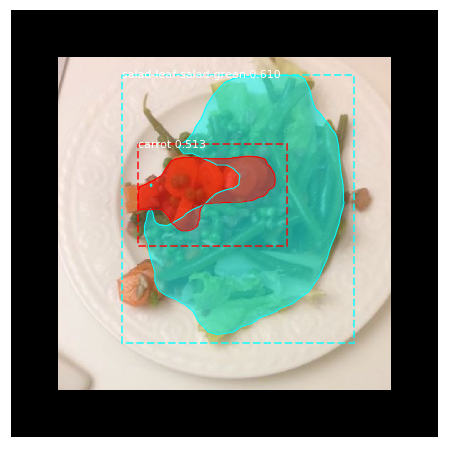

In [22]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [0]:
# Compute VOC-Style mAP
# Running on 100 images. 
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))